In [1]:
%load_ext autoreload
%autoreload 2

In [27]:
# Imports
import pandas as pd
from pathlib import Path

from cider.featurizer.dependencies import (
    filter_to_datetime,
    get_spammers_from_cdr_data,
    get_outlier_days_from_cdr_data, 
    get_static_diagnostic_statistics,
    get_timeseries_diagnostic_statistics)
from cider.featurizer.plotting import plot_timeseries_diagnostics
from cider.schemas import RechargeData, MobileDataUsageData, MobileMoneyTransactionData, CallDataRecordData

In [ ]:
# Load data
DATA_DIR = Path('../synthetic_data/')

cdr = pd.read_csv(DATA_DIR / 'cdr.csv')
cdr.rename(columns={
    "caller_antenna": "caller_antenna_id",
    "recipient_antenna": "recipient_antenna_id",
    "txn_type": "transaction_type",
    "international": "transaction_scope"}, 
    inplace=True)
cdr = cdr[~cdr.caller_antenna_id.isna()]
cdr["timestamp"] = pd.to_datetime(cdr["timestamp"])
cdr["caller_id"] = cdr["caller_id"].astype(str)
cdr["recipient_id"] = cdr["recipient_id"].astype(str)
cdr["recipient_antenna_id"] = cdr["recipient_antenna_id"].astype(str)


antennas = pd.read_csv(DATA_DIR / 'antennas.csv').dropna()


recharges = pd.read_csv(DATA_DIR / 'recharges.csv')
recharges["caller_id"] = recharges["caller_id"].astype(str)


mobile_money = pd.read_csv(DATA_DIR / 'mobilemoney.csv')
mobile_money["caller_id"] = mobile_money["caller_id"].astype(str)
mobile_money["recipient_id"] = mobile_money["recipient_id"].astype(str)
mobile_money.rename(columns={"txn_type": "transaction_type",
                             "sender_balance_before": "caller_balance_before",
                             "sender_balance_after": "caller_balance_after"}, inplace=True)
mobile_money.loc[mobile_money.recipient_id == 'nan', 'recipient_id'] = None
mobile_money['caller_balance_before'] = pd.to_numeric(mobile_money['caller_balance_before'], errors='coerce')
mobile_money['caller_balance_after'] = pd.to_numeric(mobile_money['caller_balance_after'], errors='coerce')
mobile_money.drop(mobile_money[mobile_money.caller_balance_before.isna() | mobile_money.caller_balance_after.isna()].index, inplace=True)
mobile_money.loc[
    mobile_money.transaction_type.isin(['cashin', 'cashout']), 
    ['recipient_id', 'recipient_balance_before', 'recipient_balance_after']] = None



mobile_data = pd.read_csv(DATA_DIR / 'mobiledata.csv')
mobile_data["caller_id"] = mobile_data["caller_id"].astype(str)

In [8]:
mobile_money

,transaction_type,caller_id,recipient_id,timestamp,amount,caller_balance_before,caller_balance_after,recipient_balance_before,recipient_balance_after
0,p2p,180231659,180788525.0,2020-01-01 00:15:51,55.163313,324.218747,269.055434,112.544987,167.708300
1,cashout,184232415,None,2020-01-01 00:18:59,81.860999,185.576198,103.715199,NaN,NaN
2,cashin,180474788,None,2020-01-01 00:28:17,29.225047,98.638294,127.863341,NaN,NaN
3,p2p,182560474,182475956.0,2020-01-01 00:28:29,45.561912,248.718378,203.156466,212.016381,257.578293
4,cashout,186770808,None,2020-01-01 00:31:03,55.040771,150.886443,95.845672,NaN,NaN
...,...,...,...,...,...,...,...,...,...
9995,cashout,8800184900608,None,2020-02-29 23:28:19,49.480962,181.512596,132.031633,NaN,NaN
9996,billpay,8800181154183,188204003.0,2020-02-29 23:38:55,41.737152,243.551092,201.813940,234.077080,275.814232
9997,p2p,186943395,185551902.0,2020-02-29 23:45:56,61.610272,234.244102,172.633830,156.046696,217.656968
9998,other,182314483,186770808.0,2020-02-29 23:49:41,56.923821,295.908778,238.984957,141.571551,198.495372


In [21]:
# Validate data
_ = [CallDataRecordData.model_validate(x) for x in cdr.to_dict(orient='records')]
_ = [RechargeData.model_validate(x) for x in recharges.to_dict(orient='records')]
_ = [MobileDataUsageData.model_validate(x) for x in mobile_data.to_dict(orient='records')]
_ = [MobileMoneyTransactionData.model_validate(x) for x in mobile_money.to_dict(orient='records')] # <-- TODO: not sure why this fails


ValidationError: 1 validation error for MobileMoneyTransactionData
  Value error, Recipient ID and transaction balances should be None for transaction type MobileMoneyTransactionType.CASHOUT. [type=value_error, input_value={'transaction_type': 'cas...ent_balance_after': nan}, input_type=dict]
    For further information visit https://errors.pydantic.dev/2.12/v/value_error

In [10]:
# Filter to date range
filter_start_date = pd.to_datetime("2020-01-05")
filter_end_date = pd.to_datetime("2022-02-01")

cdr_filtered = filter_to_datetime(cdr, filter_start_date, filter_end_date)
recharges_filtered = filter_to_datetime(recharges, filter_start_date, filter_end_date)
mobile_money_filtered = filter_to_datetime(mobile_money, filter_start_date, filter_end_date)
mobile_data_filtered = filter_to_datetime(mobile_data, filter_start_date, filter_end_date)

In [11]:
# Remove spammers
spammer_threshold = 1.75
spammer_ids = get_spammers_from_cdr_data(
    cdr_filtered, 
    threshold_of_calls_per_day=spammer_threshold)

cdr_filtered = cdr_filtered[~cdr_filtered.caller_id.isin(spammer_ids)]
recharges_filtered = recharges_filtered[~recharges_filtered.caller_id.isin(spammer_ids)]
mobile_money_filtered = mobile_money_filtered[~mobile_money_filtered.caller_id.isin(spammer_ids)]
mobile_data_filtered = mobile_data_filtered[~mobile_data_filtered.caller_id.isin(spammer_ids)]


/Users/poornimaramesh/Documents/IDinsight/GiveDirectly_x_Safaricom/cider/src/cider/featurizer/dependencies.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cdr_data.loc[:, "day"] = cdr_data["timestamp"].dt.date


In [12]:
# Remove outlier days
z_score_threshold = 2.0
outlier_days = get_outlier_days_from_cdr_data(cdr_filtered, z_score_threshold)

cdr_filtered = cdr_filtered[~cdr_filtered.timestamp.dt.date.isin(outlier_days)]
recharges_filtered = recharges_filtered[~recharges_filtered.timestamp.dt.date.isin(outlier_days)]
mobile_money_filtered = mobile_money_filtered[~mobile_money_filtered.timestamp.dt.date.isin(outlier_days)]
mobile_data_filtered = mobile_data_filtered[~mobile_data_filtered.timestamp.dt.date.isin(outlier_days)]

In [13]:
# Get static diagnostics
cdr_diagnostics = get_static_diagnostic_statistics(cdr_filtered)
recharges_diagnostics = get_static_diagnostic_statistics(recharges_filtered)
mobile_money_diagnostics = get_static_diagnostic_statistics(mobile_money_filtered)
mobile_data_diagnostics = get_static_diagnostic_statistics(mobile_data_filtered)

In [14]:
# Get timeseries diagnostics
cdr_timeseries_diagnostics = get_timeseries_diagnostic_statistics(cdr_filtered)
recharges_timeseries_diagnostics = get_timeseries_diagnostic_statistics(recharges_filtered)
mobile_money_timeseries_diagnostics = get_timeseries_diagnostic_statistics(mobile_money_filtered)
mobile_data_timeseries_diagnostics = get_timeseries_diagnostic_statistics(mobile_data_filtered)

/Users/poornimaramesh/Documents/IDinsight/GiveDirectly_x_Safaricom/cider/src/cider/featurizer/plotting.py:74: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(timeseries_diagnostics_df['day'], rotation=45)


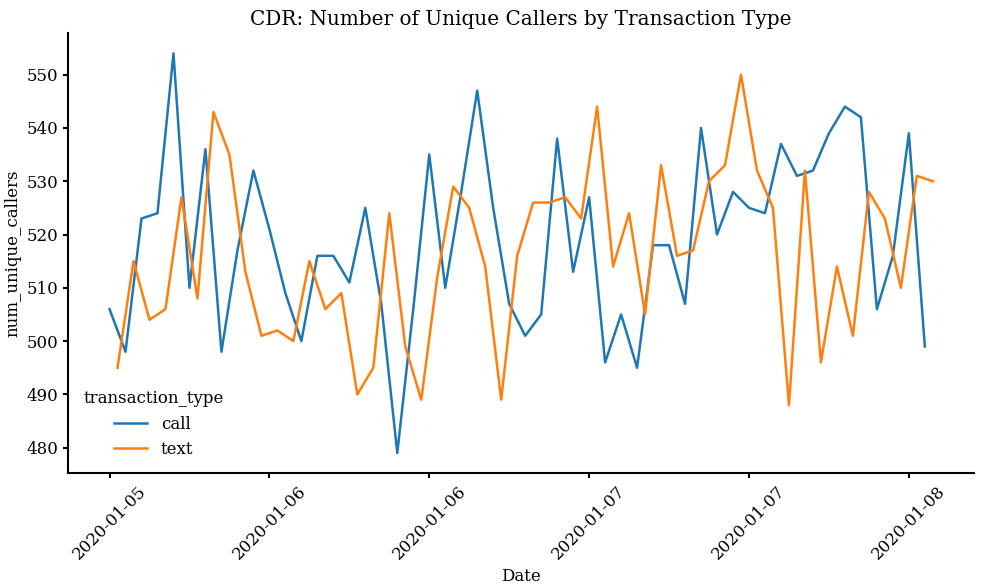

In [37]:
# Plot diagnostics
fig = plot_timeseries_diagnostics(
    cdr_timeseries_diagnostics,
    value_column="num_unique_callers",
    groupby_column="transaction_type",
    plot_title="CDR: Number of Unique Callers by Transaction Type"
    )
fig